In [4]:
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb
import os

from metrics import compute_metrics

In [2]:
def compute_miner_performance(
        wandb_validator_runs,
        miner_uid=None, 
        start_ts=None,
        end_ts=None,
        download_fake_images=False,
        validator_run_name=None):

    miner_perf = {}
    fake_image_preds = defaultdict(dict)
    for run in wandb_validator_runs:
        if run.state != 'running':
            continue
            
        if run.name != validator_run_name: 
            continue

        history_df = run.history()
        image_files = [f for f in run.files() if f.name.endswith(".png")]

        for i, challenge_row in history_df.iterrows():
            if start_ts is not None and challenge_row['_timestamp'] < start_ts:
                continue
            if end_ts is not None and challenge_row['_timestamp'] > end_ts:
                continue

            label = challenge_row['label']

            try:
                miner_preds = challenge_row['pred']
            except KeyError as e:
                miner_preds = challenge_row['predictions']
                
            try:
                miner_uids = challenge_row['miner_uid']
            except KeyError as e:
                miner_uids = challenge_row['miner_uids']
                
            if isinstance(miner_uids, dict):  
                continue  # ignore improperly formatted instances

            # compute correctness of each miner prediction for the current challenge
            for pred, uid in zip(miner_preds, miner_uids):
                if miner_uid is not None and uid != miner_uid:
                    continue
                         
                # record synthetic images and predictions (real images are not logged)
                if download_fake_images:
                    try:
                        image_path = challenge_row['image']['path']
                        challenge_image = [f for f in image_files if f.name == image_path][0]
                        if not os.path.exists(challenge_image.name):
                            challenge_image.download()
                        fake_image_preds[image_path][uid] = pred
                    except Exception as e:
                        pass

                if pred == -1:
                    continue

                if uid not in miner_perf:
                    miner_perf[uid] = defaultdict(int)

                if label == 1:      
                    if pred > 0.5:
                        miner_perf[uid]['tp'] += 1
                    else: 
                        miner_perf[uid]['fn'] += 1
                elif label == 0:
                    if pred > 0.5:
                        miner_perf[uid]['fp'] += 1
                    else: 
                        miner_perf[uid]['tn'] += 1
                            
    metrics = {uid: compute_metrics(**miner_perf[uid]) for uid in miner_perf}
    flattened_metrics = []
    for uid, metric_dict in metrics.items():
        flattened_metrics.append({'uid': uid, **metric_dict})
    metrics_df = pd.DataFrame(flattened_metrics)

    return metrics_df, fake_image_preds


### Querying mainnet wandb

In [8]:
api = wandb.Api()
project = "bitmind-subnet"  # mainnet wandb project name
entity = "bitmindai"

# must run `wandb login` and provide your W&B api key when prompted
runs = api.runs(f"{entity}/{project}")


In [6]:
metrics_df, fake_image_preds = compute_miner_performance(
    runs,
    miner_uid=0,  # example uid
    start_ts=1725982593, # example timestamp
    end_ts=None,
    download_fake_images=True)

metrics_df

,uid,accuracy,precision,recall,f1_score,sample_size
0,0,0.823045,0.847328,0.828358,0.837736,243


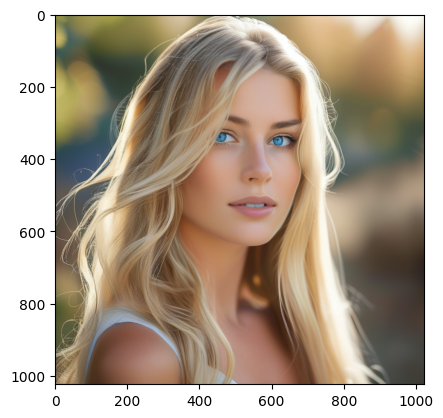

predictions: {0: 0.9953729}


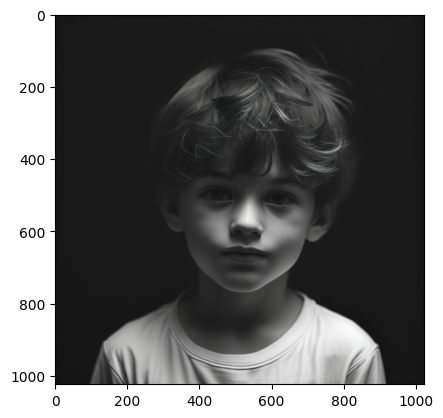

predictions: {0: 0.99939326}


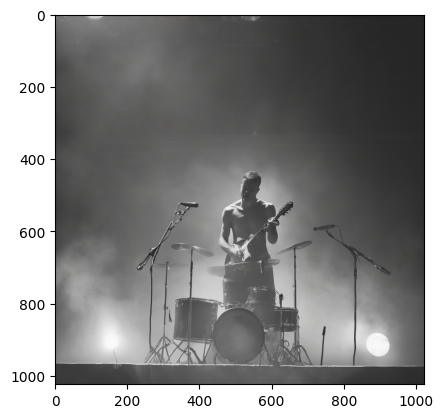

predictions: {0: 0.9941028}


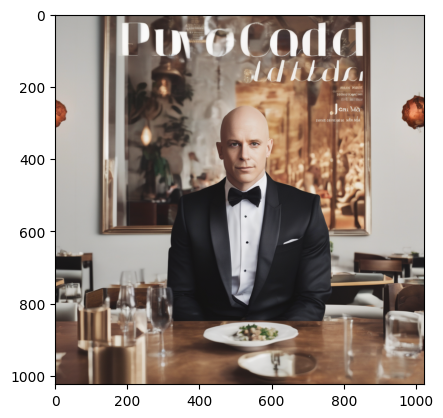

predictions: {0: 0.9915737}


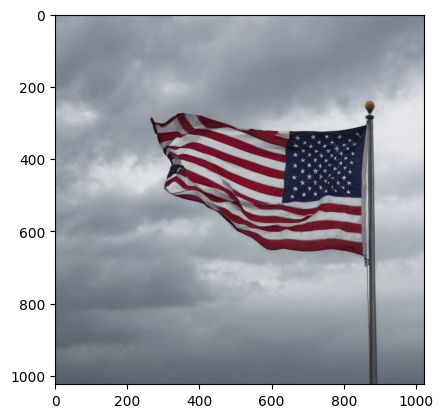

predictions: {0: 0.99651112}


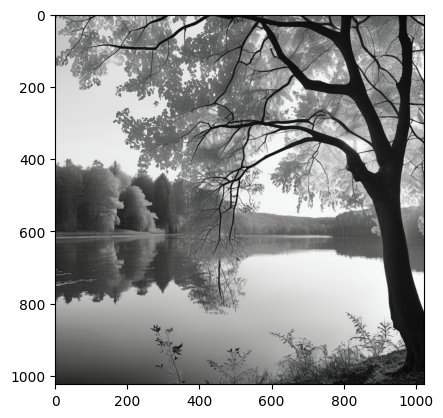

predictions: {0: 0.00221941}


In [9]:
show_N = 5
for i, path in enumerate(fake_image_preds):
    if i > show_N:
        break
    img = Image.open(path)
    plt.imshow(img)
    plt.show()
    print("predictions:", fake_image_preds[path])

### Querying testnet wandb

In [15]:
api = wandb.Api()
project = "bitmind" # testnet wandb project name
entity = "bitmindai"

# must run `wandb login` and provide your W&B api key when prompted
runs = api.runs(f"{entity}/{project}")


In [17]:
metrics_df, fake_image_preds = compute_miner_performance(
    runs,
    miner_uid=113,  # example uid
    start_ts=1726500796,  # example timestamp
    end_ts=None,
    download_fake_images=True,
    validator_run_name='validator-39-1.1.0')  # to limit your results to a trusted source (our validator)

metrics_df

,uid,accuracy,precision,recall,f1_score,sample_size
0,113,0.845588,0.857143,0.786885,0.820513,136
